In [1]:
import torch
import numpy as np
from torch import nn,optim
from torch.utils.data import Dataset, DataLoader
import pyreadr
import torch.nn.functional as F
import matplotlib.pyplot as plt 
from torch.autograd import Variable

In [2]:
# check pytorch version
print(torch.__version__)

1.4.0


In [3]:
# Define the class to get our dataset.
class Data(Dataset):
    def __init__(self, TrainSet_eonr2_df, pred_vars):
        self.x=torch.FloatTensor(TrainSet_eonr2_df[pred_vars].values)
        self.y=torch.FloatTensor(TrainSet_eonr2_df['eonr'].values)
        self.y=self.y.view(-1,1)
        self.len=self.x.shape[0]
    def __getitem__(self,index):         
        return self.x[index],self.y[index]
    def __len__(self):
        return self.len

In [6]:
# Get our training dataset.
pred_vars = pyreadr.read_r("/home/germanm2/n_policy_box/Data/files_rds/pred_vars.rds")[None] # also works for RData
pred_vars = [item for sublist in pred_vars.values.tolist()  for item in sublist]

TrainSet_eonr2_df = pyreadr.read_r("/home/germanm2/n_policy_box/Data/files_rds/TrainSet_eonr2.rds")[None] # also works for RData
data_set=Data(TrainSet_eonr2_df, pred_vars)

In [7]:
# Get our validation dataset.
prediction_set_aggregated_df = pyreadr.read_r("/home/germanm2/n_policy_box/Data/files_rds/prediction_set_aggregated_dt.rds")[None] # also works for RData
prediction_set_aggregated_df = prediction_set_aggregated_df.rename(columns={"eonr_12": "eonr"}) #needed for tha Date class
validation_set = Data(prediction_set_aggregated_df, pred_vars)

In [ ]:
# # Create the class for model 
# class Net(torch.nn.Module):
#     def __init__(self, cols):
#         super(Net, self).__init__()
#         self.hidden1 = torch.nn.Linear(cols, 21)   # hidden layer
#         self.hidden2 = torch.nn.Linear(21, 10)   # hidden layer
#         self.predict = torch.nn.Linear(10, 1)   # output layer

#     def forward(self, x):
#         x = F.relu(self.hidden1(x))      # activation function for hidden layer
#         x = F.relu(self.hidden2(x))      # activation function for hidden layer
#         x = self.predict(x)             # linear output
#         return x
    
# cols = len(pred_vars)
# model = Net(cols)

In [8]:
# Create the class for model (with Dropout)
class Net(nn.Module):
    
    # Constructor
    def __init__(self, cols, p=0):
        super(Net, self).__init__()
        #self.drop = nn.Dropout(p=p)
        self.hidden1 = torch.nn.Linear(cols, 30)   # hidden layer
        self.hidden2 = torch.nn.Linear(30, 5)   # hidden layer
        self.hidden3 = torch.nn.Linear(5, 5)   # hidden layer
        self.hidden4 = torch.nn.Linear(5, 5)   # hidden layer
        self.predict = torch.nn.Linear(5, 1)   # output layer

    def forward(self, x):
        x = F.relu(self.hidden1(x))      # activation function for hidden layer
        x = F.relu(self.hidden2(x))      # activation function for hidden layer
        x = F.relu(self.hidden3(x))      # activation function for hidden layer
        x = F.relu(self.hidden4(x))      # activation function for hidden layer
        x = self.predict(x)             # linear output
        return x
cols = len(pred_vars)
model = Net(cols, p=0.1)
# Set the model to training mode

model.train() 

Net(
  (hidden1): Linear(in_features=20, out_features=30, bias=True)
  (hidden2): Linear(in_features=30, out_features=5, bias=True)
  (hidden3): Linear(in_features=5, out_features=5, bias=True)
  (hidden4): Linear(in_features=5, out_features=5, bias=True)
  (predict): Linear(in_features=5, out_features=1, bias=True)
)

In [ ]:
# # Create the class for model (simple)
# class Net(torch.nn.Module):
#     def __init__(self, cols):
#         super(Net, self).__init__()
#         self.hidden1 = torch.nn.Linear(cols, 1)   # hidden layer
#         self.predict = torch.nn.Linear(1, 1)   # output layer

#     def forward(self, x):
#         x = F.relu(self.hidden1(x))      # activation function for hidden layer
#         x = self.predict(x)             # linear output
#         return x
    
# cols = len(pred_vars)
# model = Net(cols)

In [ ]:
# Make one prediction
x = data_set[0][0]
y = data_set[0][0]
print(model.state_dict())
print(model(x))


In [ ]:
#  Create the function to train our model, which accumulate lost for each iteration to obtain the cost.
def train_mini_batches(data_set, train_loader, validation_set, model,criterion, optimizer, epochs=5, plot_epoch = False):
    cost_training=[] 
    cost_validation=[]
    for epoch in range(epochs):
        total = 0

        for x,y in train_loader:
            optimizer.zero_grad()
            
            yhat=model(x)
            loss=criterion(yhat,y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total+=loss.item()
        cost_training.append(criterion(model(data_set.x),data_set.y))
        cost_validation.append(criterion(model(validation_set.x),validation_set.y))

    if plot_epoch:
        fig, ax1 = plt.subplots()
        color = 'tab:red'
        ax1.set_xlabel('epoch)')
        ax1.set_ylabel('cost', color=color)
        ax1.plot(cost_training, color=color, label='training') 
        ax1.tick_params(axis='y', labelcolor=color)
        ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
        color = 'tab:blue'
        ax2.set_ylabel('cost', color=color)  # we already handled the x-label with ax1
        ax2.plot(cost_validation, color=color, label='validation') 
        ax2.tick_params(axis='y', labelcolor=color)
        fig.legend()
        fig.tight_layout()  # otherwise the right y-label is slightly clipped
        plt.show()

In [9]:
def train(data_set, validation_set, model,criterion, optimizer, learning_rate, epochs=5, plot_epoch = False):
    cost_training=[] 
    cost_validation=[]  
    for epoch in range(epochs):
         #all the samples are used for training because they fit in memory
        optimizer.zero_grad()
        yhat = model(data_set.x)
        loss=criterion(yhat,data_set.y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        cost_training.append(loss)
        cost_validation.append(criterion(model(validation_set.x),validation_set.y))
#         if epoch > 500: #this will lower the learning rate at the end of the training
#             optimizer=torch.optim.Adam(model.parameters(), lr=learning_rate/10)
    if plot_epoch:
        fig, ax1 = plt.subplots()
        color = 'tab:red'
        ax1.set_xlabel('epoch)')
        ax1.set_ylabel('cost', color=color)
        ax1.plot(cost_training, color=color, label='training') 
        ax1.tick_params(axis='y', labelcolor=color)
        ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
        color = 'tab:blue'
        ax2.set_ylabel('cost', color=color)  # we already handled the x-label with ax1
        ax2.plot(cost_validation, color=color, label='validation') 
        ax2.tick_params(axis='y', labelcolor=color)
        fig.legend()
        fig.tight_layout()  # otherwise the right y-label is slightly clipped
        plt.show()
#     plt.figure()
#     plt.plot(cost_training, label='training') 
#     plt.plot(cost_validation, label='validation') 
#     plt.xlabel('epoch')
#     plt.ylabel('cost')
#     plt.legend()
#     plt.show()

In [ ]:
# # Get a single item from enumerate

# singleitem = next(iter(train_loader))
# x = singleitem[0]
# y = singleitem[1]
# yhat = model(x)

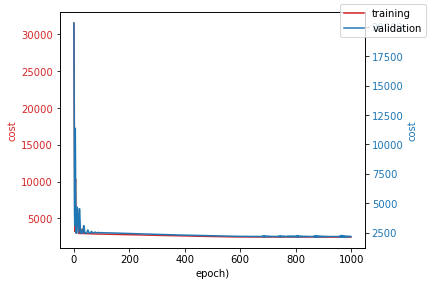

In [10]:
# Create our model 
model = Net(cols)
model.train()

torch.manual_seed(0)
learning_rate = 0.01
criterion = torch.nn.MSELoss(reduction='mean')  # this is for regression mean squared loss 
# criterion = torch.nn.L1Loss() # this is for regression mean absolute loss 

optimizer=torch.optim.Adam(model.parameters(), lr=learning_rate)

# train_loader=DataLoader(dataset=data_set,batch_size=32, shuffle=True)
# train_mini_batches(data_set, train_loader, validation_set, model,criterion, optimizer, epochs=100, plot_epoch = True)
train(data_set, validation_set, model,criterion, optimizer, learning_rate, epochs=1000, plot_epoch = True)

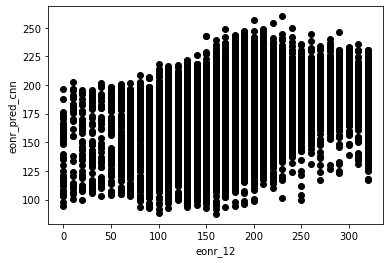

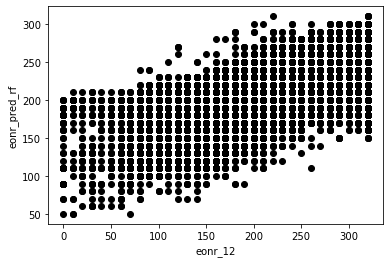

/opt/anaconda3/envs/GEOANN/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


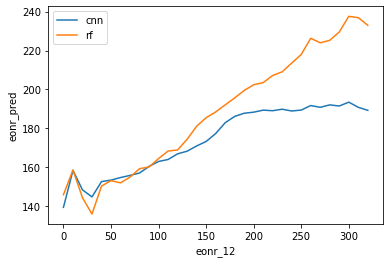

In [14]:
#Make predictions with returned model
prediction_set_aggregated_df = pyreadr.read_r("/home/germanm2/n_policy_box/Data/files_rds/prediction_set_aggregated_dt.rds")[None] # also works for RData

X = Variable(torch.FloatTensor(prediction_set_aggregated_df[pred_vars].values)) 
model.eval()
y_pred = model(X) #This outputs the value for regression
y_pred=y_pred.data[:,0].numpy()

prediction_set_aggregated_df['eonr_pred'] = y_pred


plt.figure()
plt.plot(prediction_set_aggregated_df['eonr_12'], prediction_set_aggregated_df['eonr_pred'], 'o', color='black')
plt.xlabel('eonr_12')
plt.ylabel('eonr_pred_cnn')
plt.show()

plt.figure()
plt.plot(prediction_set_aggregated_df['eonr_12'], prediction_set_aggregated_df['eonr_pred_rf'], 'o', color='black')
plt.xlabel('eonr_12')
plt.ylabel('eonr_pred_rf')
plt.show()

plot_df = prediction_set_aggregated_df.groupby('eonr_12', as_index=False)['eonr_pred','eonr_pred_rf'].mean()
plt.figure()
plt.plot(plot_df['eonr_12'], plot_df['eonr_pred'], label='cnn') 
plt.plot(plot_df['eonr_12'], plot_df['eonr_pred_rf'], label='rf') 
plt.xlabel('eonr_12')
plt.ylabel('eonr_pred')
plt.legend()
plt.show()

In [15]:
from sklearn.metrics import mean_squared_error

print(prediction_set_aggregated_df['eonr_pred'].min(),
prediction_set_aggregated_df['eonr_pred'].max(),
prediction_set_aggregated_df['eonr_pred'].mean(),
mean_squared_error(prediction_set_aggregated_df['eonr_12'], prediction_set_aggregated_df['eonr_pred']),
mean_squared_error(prediction_set_aggregated_df['eonr_12'], prediction_set_aggregated_df['eonr_pred_rf']))

87.39509582519531 259.9979553222656 181.65304565429688 2088.241333245327 1822.3474646716543


In [ ]:
4050 3472 (21, 21, 10, 1)  3322 (21,10,5,1) 2983 (10, 5, 5, 5, 1) 2167 2164

In [ ]:
y = torch.tensor([100,160],dtype=torch.float32)
yhat= torch.tensor([110,170],dtype=torch.float32)
criterion1 = torch.nn.L1Loss()
criterion2 = torch.nn.MSELoss(reduction='mean')  # this is for regression mean squared loss 
print(criterion1(y, yhat), criterion2(y, yhat))
criterion_up(y, yhat)

In [ ]:
def criterion_up(y, yhat):
    errors = yhat - y
    errors_subpred = errors[errors < 0]
    errors_overpred = errors[errors > 0]
    if errors_subpred.data.nelement()>0: #correction for zero length
        criterion_subpred = sum((errors_subpred)**2) / errors_subpred.data.nelement()
    else:
        criterion_subpred = torch.tensor([0],dtype=torch.float32)
    if errors_overpred.data.nelement()>0: #correction for zero length
        criterion_overpred = sum((errors_overpred)) / errors_overpred.data.nelement()
    else:
        criterion_overpred = torch.tensor([0],dtype=torch.float32)
    criterion = criterion_subpred.add(criterion_overpred) 
    criterion
    return(criterion)

In [ ]:
# yhat = model(data_set.x)
y = torch.tensor([100,160,170,130],dtype=torch.float32)
yhat= torch.tensor([90,170,150,150],dtype=torch.float32)

# loss=criterion_up(yhat,data_set.y)
errors = yhat - y
errors
errors_subpred = errors[errors < 0]
errors_overpred = errors[errors > 0]

if errors_subpred.data.nelement()>0: #correction for zero length
    criterion_subpred = sum((errors_subpred)**2) / errors_subpred.data.nelement()
else:
    criterion_subpred = torch.tensor([0],dtype=torch.float32)
if errors_overpred.data.nelement()>0: #correction for zero length
    criterion_overpred = sum((errors_overpred)) / errors_overpred.data.nelement()
else:
    criterion_overpred = torch.tensor([0],dtype=torch.float32)
criterion = criterion_subpred.add(criterion_overpred) 
criterion
yhat = model(data_set.x)
criterion = criterion_up
criterion(data_set.y,yhat)

In [ ]:
def build_cnn(TrainSet_eonr2_df, policy, pred_vars):
    #Define training hyperprameters.
    data_set=Data(TrainSet_eonr2_df, pred_vars)
    
    cols = len(pred_vars)

    # Create our model 
    model = Net(cols)
    model.train()

    torch.manual_seed(0)
    learning_rate = 0.01
    criterion = torch.nn.MSELoss(reduction='mean')  # this is for regression mean squared loss 
    # criterion = torch.nn.L1Loss() # this is for regression mean absolute loss 

    optimizer=torch.optim.Adam(model.parameters(), lr=learning_rate)

    train(data_set, validation_set, model,criterion, optimizer, learning_rate, epochs=1000, plot_epoch = False)

    path = '/home/germanm2/n_policy_box/Data/files_rds/cnn_models/'+ policy + '.pth'
    torch.save(model.state_dict(), path)
    return(model)  
        

In [ ]:
policy = 'ratio_5'
pred_vars = pyreadr.read_r("/home/germanm2/n_policy_box/Data/files_rds/pred_vars.rds")[None] # also works for RData
pred_vars = [item for sublist in pred_vars.values.tolist()  for item in sublist]
TrainSet_eonr2_df = pyreadr.read_r("/home/germanm2/n_policy_box/Data/files_rds/TrainSet_eonr2.rds")[None] # also works for RData
net_return = build_cnn(TrainSet_eonr2_df, policy, pred_vars)

In [ ]:
#Make predictions with returned model
prediction_set_aggregated_df = pyreadr.read_r("/home/germanm2/n_policy_box/Data/files_rds/prediction_set_aggregated_dt.rds")[None] # also works for RData

X = Variable(torch.FloatTensor(prediction_set_aggregated_df[pred_vars].values)) 

y_pred = model(X) #This outputs the value for regression
y_pred=y_pred.data[:,0].numpy()

prediction_set_aggregated_df['eonr_pred'] = y_pred

In [ ]:
#Make predictions with returned model
prediction_set_aggregated_df = pyreadr.read_r("/home/germanm2/n_policy_box/Data/files_rds/prediction_set_aggregated_dt.rds")[None] # also works for RData

X_pred = prediction_set_aggregated_df[pred_vars]

X_pred=X_pred.values

X = Variable(torch.FloatTensor(X_pred)) 
y_pred = net_return(X) #This outputs the value for regression
y_pred=y_pred.data[:,0].numpy()
y_pred
prediction_set_aggregated_df['eonr_pred'] = y_pred

# now let's write a Rds
pyreadr.write_rds("/home/germanm2/n_policy_box/Data/files_rds/prediction_set_aggregated_cnn_dt.rds", prediction_set_aggregated_df)
prediction_set_aggregated_df.head()

In [ ]:
#Load the saved model
policy = 'ratio_5'
path = '/home/germanm2/n_policy_box/Data/files_rds/cnn_models/'+ policy + '.pth'
net_load = Net(21, 100, 1)
net_load.load_state_dict(torch.load(path))
net_load.eval()
net_load.state_dict()


In [ ]:
#Make predictions with the saved model
prediction_set_aggregated_df = pyreadr.read_r("/home/germanm2/n_policy_box/Data/files_rds/prediction_set_aggregated_dt.rds")[None] # also works for RData

X_pred = prediction_set_aggregated_df[pred_vars]
X_pred=X_pred.values
X_pred
X = Variable(torch.FloatTensor(X_pred)) 
y_pred = net_load(X) #This outputs the value for regression
y_pred=y_pred.data[:,0].numpy()
y_pred
prediction_set_aggregated_df['eonr_pred'] = y_pred

# now let's write a Rds
pyreadr.write_rds("/home/germanm2/n_policy_box/Data/files_rds/prediction_set_aggregated_cnn_dt.rds", prediction_set_aggregated_df)
prediction_set_aggregated_df.head()

In [ ]:
# Make a function that loads the saved model and does predictions

prediction_set_aggregated_df = pyreadr.read_r("/home/germanm2/n_policy_box/Data/files_rds/prediction_set_aggregated_dt.rds")[None]
prediction_set_aggregated_df.head()

In [ ]:
def predict_cnn(prediction_set_aggregated_df, policy, pred_vars):
    #Load the saved model
    #policy = 'ratio_5'
    path = '/home/germanm2/n_policy_box/Data/files_rds/cnn_models/'+ policy + '.pth'
    cols = len(pred_vars)
    model = Net(cols)
    net_load = Net(21, 100, 1)
    net_load.load_state_dict(torch.load(path))
    net_load.eval()
    net_load.state_dict()
    X_pred = prediction_set_aggregated_df[pred_vars].values
    X = Variable(torch.FloatTensor(X_pred)) 
    y_pred = net_load(X) #This outputs the value for regression
    y_pred=y_pred.data[:,0].numpy()
    prediction_set_aggregated_df['eonr_pred'] = y_pred
    return(prediction_set_aggregated_df)

In [ ]:
# Use the function
prediction_set_aggregated_df2 = predict_cnn(prediction_set_aggregated_df, 'ratio_5', pred_vars)
prediction_set_aggregated_df2

In [ ]:
from sklearn.metrics import mean_squared_error

print(prediction_set_aggregated_df['eonr_pred'].min(),
prediction_set_aggregated_df['eonr_pred'].max(),
prediction_set_aggregated_df['eonr_pred'].mean(),
mean_squared_error(prediction_set_aggregated_df['eonr_12'], prediction_set_aggregated_df['eonr_pred']))

In [ ]:
# 3088
import matplotlib.pyplot as plt
import numpy as np

# Fixing random state for reproducibility
np.random.seed(19680801)


x = prediction_set_aggregated_df['eonr_12']
y = prediction_set_aggregated_df['eonr_pred']

plt.scatter(x, y, c="g", alpha=0.5, marker=r'$\clubsuit$',
            label="Luck")
plt.legend(loc='upper left')
plt.show()